In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

data_path = Path("../data/images")

image_paths = [ifp for ifp in data_path.iterdir() if "IMG" in str(ifp)]
images = [imread(im_path) for im_path in image_paths]

In [3]:
def plot_all(images, subplot_kwargs={}, imshow_kwargs={}):
    fig, axs = plt.subplots(3,6, **subplot_kwargs)
    axs = axs.flatten()
    image_index = 0
    for ax, im in zip(axs, images):
        if im is not None:
            ax.imshow(im, **imshow_kwargs)
        ax.axis('off')
        ax.set_title(str(image_index))
        image_index += 1
        
def plot_single(im, subplot_kwargs={'figsize':(5,5), 'dpi':150}, imshow_kwargs={}):
    fig, ax = plt.subplots(1,1, **subplot_kwargs)
    ax.imshow(im, **imshow_kwargs)
    ax.axis('off')

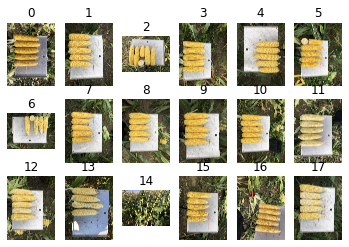

In [4]:
plot_all(images)

# Trying binary thresholding with hsv filters

In [5]:
from skimage import morphology
from skimage.morphology import disk
from scipy import ndimage
from skimage.color import rgb2hsv

def hsv_threshold(im, hmin=-0.01,hmax=1.0, smin=-0.01,smax=1.0, vmin=-0.01,vmax=1.0, plot=True):
    h = im[:,:,0]
    s = im[:,:,1]
    v = im[:,:,2]
    b_img = ((h > hmin) & (h <= hmax) &
             (s > smin) & (s <= smax) &
             (v > vmin) & (v <= vmax))
    if plot:
        plt.figure(figsize = (10,20))
        plt.imshow(b_img, cmap='gray', vmin=0, vmax=1, interpolation='nearest') # interpolation=nearest prevents matplotlib from "smoothing" the edges out
        plt.show()
    return b_img*1

def mask_hsv_filter(image, hsv_filter):
    hsv_image = rgb2hsv(image)
    mask = hsv_threshold(hsv_image, **hsv_filter, plot=False)
    
    opened = ndimage.binary_opening(mask, iterations=10)
    cleaned = morphology.remove_small_objects(opened != 0, 500000)
    dilated = ndimage.binary_dilation(cleaned,iterations=10)
    
    return dilated

tray_filter = {
    'hmin' : -0.01,
    'hmax' : 1.01,
    'smin' : -0.01,
    'smax' : 0.25,
    'vmin' : -0.01,
    'vmax' : 1.01
}

corn_filter = {
    'hmin' : 0.10,
    'hmax' : 0.20,
    'smin' : 0.36,
    'smax' : 1.01,
    'vmin' : 0.23,
    'vmax' : 1.01
}

In [6]:
masks = list(map(lambda x : mask_hsv_filter(x, tray_filter) | mask_hsv_filter(x, corn_filter), images))

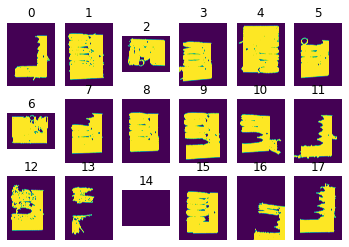

In [7]:
plot_all(masks)

# Multi-Otsu Thresholding ?

In [8]:
from skimage.filters import threshold_multiotsu
from skimage.color import rgb2gray 
import numpy as np

def mo_mask(image, num_classes=5, min_class=2):
    gray = rgb2gray(image)
    thresholds = threshold_multiotsu(gray, classes=num_classes)
    regions = np.digitize(gray, bins=thresholds)
    
    opened = ndimage.binary_opening(regions > min_class, iterations=10)
    cleaned = morphology.remove_small_objects(opened != 0, 250000)
    dilated = ndimage.binary_dilation(cleaned,iterations=10)
    return dilated

In [9]:
mos = list(map(mo_mask, images))

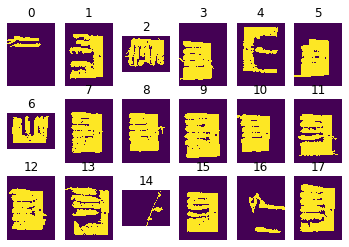

In [10]:
plot_all(mos, imshow_kwargs={'interpolation':'Nearest'})

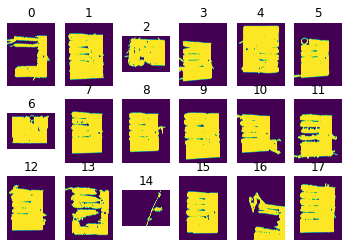

In [11]:
combined_masks = [m1 | m2 for m1,m2 in zip(mos, masks)]
plot_all(combined_masks)

In [12]:
def crop_by_mask(image, mask):
    chull = morphology.convex_hull_image(mask)
    if chull.any():
        [rows, columns] = np.where(chull)
        row1 = min(rows)
        row2 = max(rows)
        col1 = min(columns)
        col2 = max(columns)
        return image[row1:row2, col1:col2]
    else:
        return None
    
cropped_images = []
    
for image, mask in zip(images, combined_masks):
    cropped_images.append(crop_by_mask(image, mask))

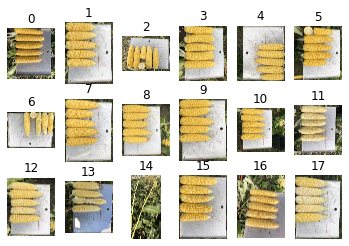

In [13]:
plot_all(cropped_images)

Save the cropped images

In [48]:
from skimage.io import imsave

In [56]:
cropped_image_path = Path("../data/cropped/")
cropped_image_path.mkdir(parents=True, exist_ok=True)

for cropped_image, image_path in zip(cropped_images, image_paths):
    filename = image_path.name
    imsave(f"{cropped_image_path}/C{filename}", cropped_image)